## **Optimized Fuzzy Matching**

**References:**

article: https://bergvca.github.io/2017/10/14/super-fast-string-matching.html

and this one also: https://towardsdatascience.com/fuzzy-matching-at-scale-84f2bfd0c536

original colab: https://colab.research.google.com/drive/1qhBwDRitrgapNhyaHGxCW8uKK5SWJblW

**Notes:**
please load this document first:
https://drive.google.com/file/d/1EAXvkiik5EO8FcpEwfX3muQEm6cqPGrQ/view?usp=sharing

## **Dataset Loader**

In [ ]:
def algorithm(word, wordList):
  # create feature vector for all words
  # find cosine similarity
  # return closets word
  combinedList = ['asd', 'asdasd']
  ngram(word): 
  pass

In [ ]:
!pip install googledrivedownloader
from google_drive_downloader import GoogleDriveDownloader as gdd
import pandas as pd

In [ ]:
class DataSetLoader:
  # some attributes
  google_drive_file_id = '1vcaNbiZkZ-6ZORn-S_UbdGY3kGrCx4O7'
  target_column_name = 'headline_text'
  # google_drive_file_id = '1pq9EF8_4K5KLMNok4BF5TRTcvmHseXHF'
  # target_column_name = 'buyer'
  local_file_dir = './dataset.csv'
  dataset = None

  # load dataset
  def download_and_load_dataset(_self):
    # download dataset
    gdd.download_file_from_google_drive(file_id=_self.google_drive_file_id, dest_path=_self.local_file_dir, overwrite=True)
    # load dataset
    dataset =  pd.read_csv(_self.local_file_dir,encoding='latin')
    _self.dataset = dataset[_self.target_column_name].unique()

  # get lists
  def get_utterancelist_and_sentencelist(_self, utterance_list_size, sentence_list_size):
    # create lists
    utterance_list = _self.dataset[0:utterance_list_size].tolist()
    sentence_list = _self.dataset[utterance_list_size:sentence_list_size + utterance_list_size].tolist()
    # return result
    return utterance_list, sentence_list

# **Edit Distance Similarity**

In [ ]:
class SimilarityEditDistance:
  # calculate edit distance
  def calculate_edit_distance(_self, word1, word2):
    size_a = len(word1)
    size_b = len(word2)
    dp = [[0 for _ in range(size_b + 1)] for _ in range(size_a + 1)]
    for i in range(size_a + 1):
        dp[i][0] = i        
    for i in range(size_b + 1):
        dp[0][i] = i
    for i in range(1, size_a + 1):
        for j in range(1, size_b + 1):
            if word1[i - 1] == word2[j - 1]:
                dp[i][j] = dp[i - 1][j - 1]
            else:
                dp[i][j] = min(dp[i - 1][j - 1], dp[i - 1][j], dp[i][j - 1]) + 1
    return dp[size_a][size_b]

  # match similarity for single utterance
  def match_similarity(_self, utterance, sentence_list):
    min_distance = 10000000
    closest_string = ""
    for sentence in sentence_list:
      distance = _self.calculate_edit_distance(utterance, sentence)
      if (distance < min_distance):
        min_distance = distance
        closest_string = sentence
    return closest_string, min_distance

  # match similarity for single utterance batch
  def match_similarity_batch(_self, utterance_list, sentence_list):
    result = []
    for utterance in utterance_list:
      closest_string, min_distance = _self.match_similarity(utterance, sentence_list)
      result.append( (utterance, closest_string, min_distance) )
    return result

## **TF-IDF Cosine Similarity - No Preprocessing**

In [ ]:
import sys
import time
import pandas as pd
pd.set_option('display.max_colwidth', -1)
from tqdm import tqdm
from google.colab import drive
import os
from matplotlib import style
style.use('fivethirtyeight')

# cosine similarity
import numpy as np
from scipy.sparse import csr_matrix
!pip install sparse_dot_topn #uncomment to install
import sparse_dot_topn.sparse_dot_topn as ct

# ngrams
import re
!pip install ftfy # amazing text cleaning for decode issues..
from ftfy import fix_text

# feature matrix
from sklearn.feature_extraction.text import TfidfVectorizer

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


     |████████████████████████████████| 112kB 5.5MB/s 
  Created wheel for sparse-dot-topn: filename=sparse_dot_topn-0.2.9-cp36-cp36m-linux_x86_64.whl size=322974 sha256=6e280bb3340e1984d8151e005be465ec7f12b7c47b9c279f0e043b8a294df1c9
  Stored in directory: /root/.cache/pip/wheels/aa/e7/c7/e64559d518bcc12ed7e40a605ae304259b957ae8181c8d1e82
Successfully built sparse-dot-topn
     |████████████████████████████████| 71kB 3.5MB/s 
  Created wheel for ftfy: filename=ftfy-5.8-cp36-none-any.whl size=45613 sha256=1eea02e09b4e7d604a8ff9f2271a0477ed3ed83a47d27bfa6ea674207983ecfe
  Stored in directory: /root/.cache/pip/wheels/ba/c0/ef/f28c4da5ac84a4e06ac256ca9182fc34fa57fefffdbc68425b
Successfully built ftfy


In [ ]:
class SimilarityTFIDFNoPreProcessingMatcher:
  # generate ngrams
  def ngrams(_self, string, n=3):
      string = fix_text(string) # fix text
      string = string.encode("ascii", errors="ignore").decode() #remove non ascii chars
      string = string.lower()
      chars_to_remove = [")","(",".","|","[","]","{","}","'"]
      rx = '[' + re.escape(''.join(chars_to_remove)) + ']'
      string = re.sub(rx, '', string)
      string = string.replace('&', 'and')
      string = string.replace(',', ' ')
      string = string.replace('-', ' ')
      string = string.title() # normalise case - capital at start of each word
      string = re.sub(' +',' ',string).strip() # get rid of multiple spaces and replace with a single
      string = ' '+ string +' ' # pad names for ngrams...
      string = re.sub(r'[,-./]|\sBD',r'', string)
      ngrams = zip(*[string[i:] for i in range(n)])
      return [''.join(ngram) for ngram in ngrams]

  # cosine similarity
  def apply_cosine_similarity(_self, A, B, ntop, lower_bound=0):
      # force A and B as a CSR matrix.
      # If they have already been CSR, there is no overhead
      A = A.tocsr()
      B = B.tocsr()
      M, _ = A.shape
      _, N = B.shape
      idx_dtype = np.int32
      nnz_max = M*ntop
      indptr = np.zeros(M+1, dtype=idx_dtype)
      indices = np.zeros(nnz_max, dtype=idx_dtype)
      data = np.zeros(nnz_max, dtype=A.dtype)
      ct.sparse_dot_topn(
          M, N, np.asarray(A.indptr, dtype=idx_dtype),
          np.asarray(A.indices, dtype=idx_dtype),
          A.data,
          np.asarray(B.indptr, dtype=idx_dtype),
          np.asarray(B.indices, dtype=idx_dtype),
          B.data,
          ntop,
          lower_bound,
          indptr, indices, data)
      return csr_matrix((data,indices,indptr),shape=(M,N))

  # combine lists
  def create_comparison_list(_self, utterance_list, sentence_list):
    return np.array(utterance_list + sentence_list)

  # create feature matrix
  def create_feature_matrix(_self, utterance_list, sentence_list, comparator_function):
    # append utterance to list
    comparison_list = _self.create_comparison_list(utterance_list, sentence_list)
    # create feature matrix
    vectorizer = TfidfVectorizer(min_df=1, analyzer=comparator_function)
    return vectorizer.fit_transform(comparison_list)

  # match similarity
  def match_similarity_batch(_self, utterance_list, sentence_list):
    # prepare
    n = len(utterance_list)
    # create feature matrix
    feature_matrix = _self.create_feature_matrix(utterance_list, sentence_list, _self.ngrams)
    # get matches from cosine similarity
    source_utterance_features = feature_matrix[0:n]
    sentence_list_features = feature_matrix[n:]
    matches = _self.apply_cosine_similarity(source_utterance_features, sentence_list_features.transpose(), 10, 0.85)
    # get index of highest scoring sentence
    result = []
    for i in range(0, len(utterance_list)):
      utterance = utterance_list[i]
      index = matches[i].argmax(axis=1)[0,0]
      score = matches[i, index]
      matching_sentence = sentence_list[index]
      result.append( (utterance, matching_sentence, score) )
    # return 
    return result

## **Cosine Similarity TF-IDF - with preprocessing**

adding new utterance to feature matrix: https://stackoverflow.com/questions/39109743/adding-new-text-to-sklearn-tfidif-vectorizer-python

In [ ]:
import sys
import time
import pandas as pd
pd.set_option('display.max_colwidth', -1)
from tqdm import tqdm
import os
from matplotlib import style
style.use('fivethirtyeight')

import numpy as np
from scipy.sparse.dia import dia_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

import re
!pip install ftfy # amazing text cleaning for decode issues..
from ftfy import fix_text

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


utilities

In [ ]:
import pickle

class BinaryObjectStorageHandler:
  # store method
  def store_object(some_object, file_dir):
    with open(file_dir, 'wb') as output:
        pickle.dump(some_object, output, pickle.HIGHEST_PROTOCOL)

  # load metho
  def load_object(file_dir):
    with open(file_dir, 'rb') as input:
        return pickle.load(input)

preprocessor

In [ ]:
class SimilarityTFIDFWithPreProcessingPreprocessor:
  # comparator function
  def ngrams(_self, string, n=3):
      string = fix_text(string) # fix text
      string = string.encode("ascii", errors="ignore").decode() #remove non ascii chars
      string = string.lower()
      chars_to_remove = [")","(",".","|","[","]","{","}","'"]
      rx = '[' + re.escape(''.join(chars_to_remove)) + ']'
      string = re.sub(rx, '', string)
      string = string.replace('&', 'and')
      string = string.replace(',', ' ')
      string = string.replace('-', ' ')
      string = string.title() # normalise case - capital at start of each word
      string = re.sub(' +',' ',string).strip() # get rid of multiple spaces and replace with a single
      string = ' '+ string +' ' # pad names for ngrams...
      string = re.sub(r'[,-./]|\sBD',r'', string)
      ngrams = zip(*[string[i:] for i in range(n)])
      return [''.join(ngram) for ngram in ngrams]

  # create vectorizer
  def create_vectorizer_internal(_self, sentence_list, comparator_function):
    vec = TfidfVectorizer(min_df=1, analyzer=comparator_function)
    tmp = vec.fit_transform(sentence_list)
    vec.n_docs = len(sentence_list)
    return vec, tmp

  # create vectorizer
  def create_and_store_vectorizer(_self, sentence_list, target_file):
    vectorizer, features = _self.create_vectorizer_internal(sentence_list, _self.ngrams)
    BinaryObjectStorageHandler.store_object(vectorizer, target_file)
    BinaryObjectStorageHandler.store_object(features, "./arr.pkl")

runtime

In [ ]:
# partial fit method
def partial_fit(self, X):
    max_idx = max(self.vocabulary_.values())
    for a in X:
        #update vocabulary_
        if self.lowercase: a = a.lower()
        tokens = re.findall(self.token_pattern, a)
        for w in tokens:
            if w not in self.vocabulary_:
                max_idx += 1
                self.vocabulary_[w] = max_idx
        #update idf_
        df = (self.n_docs + self.smooth_idf)/np.exp(self.idf_ - 1) - self.smooth_idf
        self.n_docs += 1
        df.resize(len(self.vocabulary_))
        for w in tokens:
            df[self.vocabulary_[w]] += 1
        idf = np.log((self.n_docs + self.smooth_idf)/(df + self.smooth_idf)) + 1
        self._tfidf._idf_diag = dia_matrix((idf, 0), shape=(len(idf), len(idf)))

class SimilarityTFIDFWithPreProcessingMatcher:
   # cosine similarity
  def apply_cosine_similarity(_self, A, B, ntop, lower_bound=0):
      # force A and B as a CSR matrix.
      # If they have already been CSR, there is no overhead
      A = A.tocsr()
      B = B.tocsr()
      M, _ = A.shape
      _, N = B.shape
      idx_dtype = np.int32
      nnz_max = M*ntop
      indptr = np.zeros(M+1, dtype=idx_dtype)
      indices = np.zeros(nnz_max, dtype=idx_dtype)
      data = np.zeros(nnz_max, dtype=A.dtype)
      ct.sparse_dot_topn(
          M, N, np.asarray(A.indptr, dtype=idx_dtype),
          np.asarray(A.indices, dtype=idx_dtype),
          A.data,
          np.asarray(B.indptr, dtype=idx_dtype),
          np.asarray(B.indices, dtype=idx_dtype),
          B.data,
          ntop,
          lower_bound,
          indptr, indices, data)
      return csr_matrix((data,indices,indptr),shape=(M,N))
  # similarity matching
  def match_similarity_batch(_self, utterance_list, sentence_list, vectorizer_path):
    # load vectorizer
    vec = BinaryObjectStorageHandler.load_object(vectorizer_path)
    sentences_features = BinaryObjectStorageHandler.load_object("./arr.pkl")
    # sentences_features = sentences_features[0:len(sentence_list),:]
    # runtime step
    TfidfVectorizer.partial_fit = partial_fit
    #vec.partial_fit(utterance_list)
    utterances_features = vec.transform(utterance_list)
    # get matches from cosine similarity
    matches = _self.apply_cosine_similarity(utterances_features, sentences_features.transpose(), 10, 0.85)
    # get index of highest scoring sentence
    result = []
    for i in range(0, len(utterance_list)):
      utterance = utterance_list[i]
      index = matches[i].argmax(axis=1)[0,0]
      score = matches[i, index]
      matching_sentence = sentence_list[index]
      result.append( (utterance, matching_sentence, score) )
    return result

## **Load Testing**

 parameters
 
    - input count
        - dataset size: [10, 100, 1000, 10k, 20k]
        - query list: [1, 10, 100, ..]
    - string length
        - dataset entry length
        - query length
    - list structure
    - comparison approach
        - edit distance                         [without preprocessing]
        - cosine similarity (TF-IDF)            [with and without preprocessing]
        - luis exact match for list entities    [pending]

In [ ]:
def single_test(dataset_loader, utterance_list_size, sentence_list_size):
  # load data
  utterance_list, sentence_list = dataset_loader.get_utterancelist_and_sentencelist(utterance_list_size, sentence_list_size)

  # # run edit distance
  # edit_distance = SimilarityEditDistance()
  # ts = time.time()
  # edit_distance.match_similarity_batch(utterance_list, sentence_list)
  # time1 = time.time() - ts
  time1=0

  # run tfidf without preprocessing
  tfidf_no_preprocessing = SimilarityTFIDFNoPreProcessingMatcher()
  ts = time.time()
  tfidf_no_preprocessing.match_similarity_batch(utterance_list, sentence_list)
  time2 = time.time() - ts

  # run tfidf with preprocessing
  # preprocessor step
  vectorizer_file_dir = "./vectorizer.pkl"
  preprocessor = SimilarityTFIDFWithPreProcessingPreprocessor()
  preprocessor.create_and_store_vectorizer(sentence_list, vectorizer_file_dir)

  # runtime step
  similarity_matcher = SimilarityTFIDFWithPreProcessingMatcher()
  ts = time.time()
  match_result2 = similarity_matcher.match_similarity_batch(utterance_list, sentence_list, vectorizer_file_dir)
  time3 = time.time() - ts

  # return
  return (time1, time2, time3)

10
100
1000
10000
20000
[[[0, 0.003999233245849609, 0.0016243457794189453], [0, 0.005962371826171875, 0.003886699676513672]], [[0, 0.012890815734863281, 0.0023589134216308594], [0, 0.014739513397216797, 0.004753828048706055]], [[0, 0.10613393783569336, 0.004708290100097656], [0, 0.09184980392456055, 0.007620573043823242]], [[0, 0.8362610340118408, 0.015773534774780273], [0, 0.8439946174621582, 0.02016139030456543]], [[0, 1.6433982849121094, 0.03191256523132324], [0, 1.6581671237945557, 0.035620689392089844]]]
(5, 2, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log


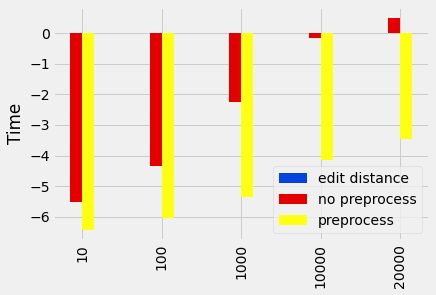

In [ ]:
# load dataset
dataset_loader = DataSetLoader()
dataset_loader.download_and_load_dataset()

# configure parms
utterance_list_sizes = [1, 10]#, 100, 500]
sentence_list_sizes = [10, 100, 1000, 10000, 20000]

result = []

# run tests
for sentence_list_size in sentence_list_sizes:
  print(sentence_list_size)
  d1 = []
  for utterance_list_size in utterance_list_sizes:
    t1, t2, t3 = single_test(dataset_loader, utterance_list_size, sentence_list_size)
    d1.append([t1, t2, t3])
  result.append(d1)

print(result)
tmp = np.array(result)

# write to file
file = open("resultArr", "wb")
np.save(file, result)
file.close
result = np.log(tmp)

print(result.shape)
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# A little data preparation
sizes = [str(i) for i in sentence_list_sizes]
x = np.arange(len(sizes))
width = 0.15

# Plot each bar plot. Note: manually calculating the 'dodges' of the bars
ax.bar(x - 3*width/2, result[:,0,0], width, label='edit distance', color='#0343df')
ax.bar(x - width/2, result[:,0,1], width, label='no preprocess', color='#e50000')
ax.bar(x + width/2, result[:,0,2], width, label='preprocess', color='#ffff14')

# Customise some display properties
ax.set_ylabel('Time')
ax.set_xticks(x)    # This ensures we have one tick per year, otherwise we get fewer
ax.set_xticklabels(sizes, rotation='vertical')
ax.legend()

# Ask Matplotlib to show the plot
plt.show()

(5, 2, 3)


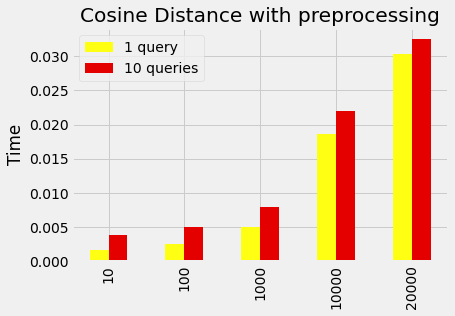

In [ ]:
import numpy as np

# configure parms
utterance_list_sizes = [1, 10, 100, 500]
sentence_list_sizes = [10, 100, 1000, 10000, 20000]

result = []
result.append([[[0, 0.004275798797607422, 0.001767873764038086], [0, 0.006043195724487305, 0.0040111541748046875]], [[0, 0.012948989868164062, 0.0026047229766845703], [0, 0.016620635986328125, 0.005438566207885742]], [[0, 0.10017824172973633, 0.0047550201416015625], [0, 0.09229230880737305, 0.007485389709472656]], [[0, 0.8421554565429688, 0.01674056053161621], [0, 0.8598895072937012, 0.02068352699279785]], [[0, 1.6626455783843994, 0.028696537017822266], [0, 1.6508851051330566, 0.03372788429260254]]])
result.append([[[0, 0.004827260971069336, 0.001720428466796875], [0, 0.0059223175048828125, 0.003920316696166992]], [[0, 0.13001370429992676, 0.0025339126586914062], [0, 0.014837980270385742, 0.007491588592529297]], [[0, 0.09318375587463379, 0.0051462650299072266], [0, 0.10021018981933594, 0.007293224334716797]], [[0, 0.8525230884552002, 0.01570296287536621], [0, 0.831655740737915, 0.02130603790283203]], [[0, 1.684692144393921, 0.03030991554260254], [0, 1.6700401306152344, 0.03558945655822754]]])
result.append([[[0, 0.0039577484130859375, 0.001758575439453125], [0, 0.00608372688293457, 0.004508018493652344]], [[0, 0.013242483139038086, 0.002655029296875], [0, 0.01498723030090332, 0.004999637603759766]], [[0, 0.09087967872619629, 0.004946470260620117], [0, 0.09885764122009277, 0.009286165237426758]], [[0, 0.8502545356750488, 0.014743566513061523], [0, 0.8486065864562988, 0.020524978637695312]], [[0, 1.6537344455718994, 0.03352618217468262], [0, 1.6980571746826172, 0.035097599029541016]]])
result.append([[[0, 0.004828214645385742, 0.0017542839050292969], [0, 0.006005525588989258, 0.004017353057861328]], [[0, 0.013204336166381836, 0.0025064945220947266], [0, 0.015186071395874023, 0.005008697509765625]], [[0, 0.09062480926513672, 0.004876136779785156], [0, 0.09192585945129395, 0.007459163665771484]], [[0, 0.8477497100830078, 0.014615297317504883], [0, 0.8394958972930908, 0.01956939697265625]], [[0, 1.672548532485962, 0.02754354476928711], [0, 1.6949853897094727, 0.03250455856323242]]])

result = np.mean(np.array(result), axis=0)

print(result.shape)
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# A little data preparation
sizes = [str(i) for i in sentence_list_sizes]
x = np.arange(len(sizes))
width = 0.25

# Plot each bar plot. Note: manually calculating the 'dodges' of the bars
# ax.bar(x - 3*width/2, result[:,0,0], width, label='edit distance', color='#0343df')
# ax.bar(x - width/2, result[:,0,1], width, label='no preprocess', color='#e50000')
ax.bar(x - width/2, result2[:,0,2], width, label='1 query', color='#ffff14')
ax.bar(x + width/2, result2[:,1,2], width, label='10 queries', color='#e50000')

# Customise some display properties
ax.set_ylabel('Time')
ax.set_title('Cosine Distance with preprocessing')
ax.set_xticks(x)    # This ensures we have one tick per year, otherwise we get fewer
ax.set_xticklabels(sizes, rotation='vertical')
ax.legend()

# Ask Matplotlib to show the plot
plt.show()